# Create model for FOMO detector

In [ ]:
import os
import glob
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/train'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model16x16'

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)  # FOMO grid
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
BATCH_SIZE = 32
EPOCHS = 50
SAMPLES_FOR_CALIBRATION = 100

# Funkce na načtení dat
def load_fomo_data(data_dir):
    images = []
    target_grids = []

    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        # Inicializuj target grid
        grid = np.zeros(GRID_SIZE, dtype=np.float32)

        # Načti bounding boxy
        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    # Převést normalizované souřadnice do pixelů
                    x_pixel = int(x_center * IMG_SIZE[0])
                    y_pixel = int(y_center * IMG_SIZE[1])

                    # Najít odpovídající buňku
                    grid_x = min(x_pixel // CELL_WIDTH, GRID_SIZE[0] - 1)
                    grid_y = min(y_pixel // CELL_HEIGHT, GRID_SIZE[1] - 1)

                    # Označit buňku jako obsahující objekt
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            gx = grid_x + dx
                            gy = grid_y + dy
                            if 0 <= gx < GRID_SIZE[0] and 0 <= gy < GRID_SIZE[1]:
                                grid[gy, gx] = max(grid[gy, gx], 0.5 if (dx != 0 or dy != 0) else 0.9)

        images.append(img)
        target_grids.append(grid[..., np.newaxis])  # přidat kanál

    return np.array(images, dtype=np.float32), np.array(target_grids, dtype=np.float32)

# Nahrání dat

images, grids = load_fomo_data(DATA_DIR)
print(f"Dataset loaded: {images.shape} images, {grids.shape} grids")

# Rozdělení na train/val
train_images = images
train_grids = grids
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model
def create_fomo_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.keras.layers.Resizing(GRID_SIZE[0], GRID_SIZE[1])(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

model = create_fomo_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Připrav CSV Logger
csv_log_path = os.path.join(MODEL_DIR, 'fomo_training_log.csv')
csv_logger = CSVLogger(csv_log_path)

# Trénování
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]  # přidáno logování metrik
)

# Uložení TensorFlow modelu
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

tf_model_path = os.path.join(MODEL_DIR, 'fomo_detector_tf')
model.save(tf_model_path)
print(f"FOMO-like TensorFlow model uložen do: {tf_model_path}")

# Převod do TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

tflite_model_path = os.path.join(MODEL_DIR, 'fomo_detector.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved to {tf_model_path} and {tflite_model_path}")

# Kvantizace na INT8
def representative_dataset():
    for i in range(min(SAMPLES_FOR_CALIBRATION, len(train_images))):
        img = train_images[i]
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Ulozeni kvantizovaného modelu
quant_model_path = os.path.join(MODEL_DIR, 'fomo_detector_int8.tflite')
model.trainable = False
with open(quant_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Kvantizovaný INT8 model uložen do: {quant_model_path}")


# Test quantized model FOMO


1/1 [==============================] - 0s 18ms/step


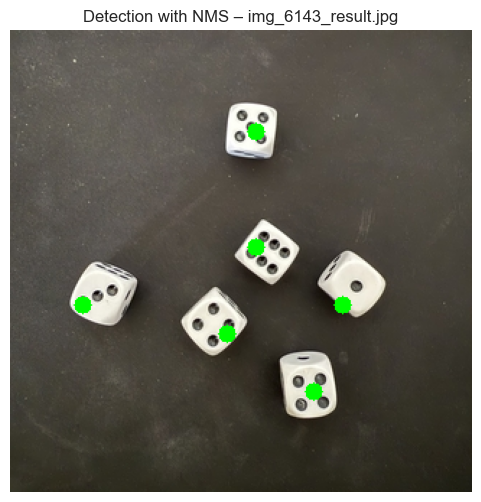

In [15]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model16x16'

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
THRESHOLD = 0.35
NMS_SIZE = 3  # okolí pro maximální filtr

# Načti model
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'fomo_detector_tf'))

# Funkce na výběr náhodného obrázku
def load_random_image():
    image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    img_path = np.random.choice(image_files)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
    return img_rgb, np.expand_dims(img_resized.astype(np.float32), axis=0), os.path.basename(img_path)

# Non-Maximum Suppression pro FOMO výstup
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

# Načtení obrázku a predikce
orig_img, input_img, img_name = load_random_image()
h_orig, w_orig = orig_img.shape[:2]

pred = model.predict(input_img)[0].squeeze()
grid_h, grid_w = pred.shape

scale_x = w_orig / grid_w
scale_y = h_orig / grid_h

# Aplikuj NMS
detections = apply_nms(pred, threshold=THRESHOLD, size=NMS_SIZE)

# Vykresli výsledek
for (y, x) in detections:
    cx = int((x + 0.5) * scale_x)
    cy = int((y + 0.5) * scale_y)
    cv2.circle(orig_img, (cx, cy), 6, (0, 255, 0), -1)

# Zobraz
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
plt.title(f"Detection with NMS – {img_name}")
plt.axis('off')
plt.show()


# Create model FOMO - advance

Script has calculation Precision, Recall, F1-score a IoU,

In [ ]:
import os
import glob
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

# === Definice vlastních metrik ===
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + tf.keras.backend.epsilon())

def iou_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool),
                                                     tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/train'
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model16x16'

# === Parametry ===
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)  # FOMO grid
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
BATCH_SIZE = 32
EPOCHS = 50
SAMPLES_FOR_CALIBRATION = 100

# === Načítání dat ===
def load_fomo_data(data_dir):
    images = []
    target_grids = []
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        grid = np.zeros(GRID_SIZE, dtype=np.float32)

        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, width, height = map(float, parts)
                        x_pixel = int(x_center * IMG_SIZE[0])
                        y_pixel = int(y_center * IMG_SIZE[1])
                        grid_x = min(x_pixel // CELL_WIDTH, GRID_SIZE[0] - 1)
                        grid_y = min(y_pixel // CELL_HEIGHT, GRID_SIZE[1] - 1)

                        for dy in [-1, 0, 1]:
                            for dx in [-1, 0, 1]:
                                gx = grid_x + dx
                                gy = grid_y + dy
                                if 0 <= gx < GRID_SIZE[0] and 0 <= gy < GRID_SIZE[1]:
                                    grid[gy, gx] = max(grid[gy, gx], 0.5 if (dx or dy) else 0.9)

        images.append(img)
        target_grids.append(grid[..., np.newaxis])

    return np.array(images, dtype=np.float32), np.array(target_grids, dtype=np.float32)

# === Načtení dat ===
train_images, train_grids = load_fomo_data(DATA_DIR)
val_images, val_grids = load_fomo_data(VAL_DIR)
print(f"Train: {train_images.shape}, Validation: {val_images.shape}")

# === Dataset ===
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_grids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Definice modelu ===
def create_fomo_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.keras.layers.Resizing(GRID_SIZE[0], GRID_SIZE[1])(x)
    return tf.keras.Model(inputs, x)

# === Trénování modelu ===
model = create_fomo_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_score, iou_m]
)

csv_logger = CSVLogger(os.path.join(MODEL_DIR, 'fomo_training_log.csv'))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]
)

# === Uložení modelu ===
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

tf_model_path = os.path.join(MODEL_DIR, 'fomo_detector_tf')
model.save(tf_model_path)

# === Export do TFLite ===
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector.tflite'), 'wb') as f:
    f.write(tflite_model)

# === Kvantizace na INT8 ===
def representative_dataset():
    for i in range(min(SAMPLES_FOR_CALIBRATION, len(train_images))):
        img = train_images[i]
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector_int8.tflite'), 'wb') as f:
    f.write(quant_model)


# Testing FOMO - advance

Script for visualization detection is advance with metrics.

1/1 [==============================] - 0s 17ms/step


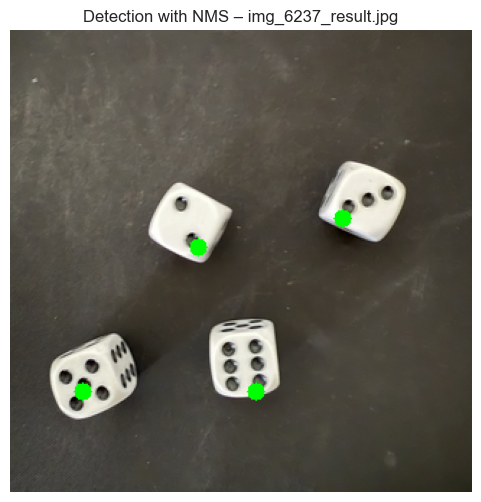

In [22]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# === Definice vlastních metrik ===
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + tf.keras.backend.epsilon())

def iou_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool),
                                                     tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model16x16'

# === Parametry ===
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
THRESHOLD = 0.35
NMS_SIZE = 3

# === Načti model s vlastními metrikami ===
model = tf.keras.models.load_model(
    os.path.join(MODEL_DIR, 'fomo_detector_tf'),
    custom_objects={
        'f1_score': f1_score,
        'precision_m': precision_m,
        'recall_m': recall_m,
        'iou_m': iou_m
    }
)

# === Funkce na výběr náhodného obrázku ===
def load_random_image():
    image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    img_path = np.random.choice(image_files)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
    return img_rgb, np.expand_dims(img_resized.astype(np.float32), axis=0), os.path.basename(img_path)

# === Non-Maximum Suppression ===
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

# === Načtení obrázku a predikce ===
orig_img, input_img, img_name = load_random_image()
h_orig, w_orig = orig_img.shape[:2]

pred = model.predict(input_img)[0].squeeze()
grid_h, grid_w = pred.shape

scale_x = w_orig / grid_w
scale_y = h_orig / grid_h

# === Aplikuj NMS ===
detections = apply_nms(pred, threshold=THRESHOLD, size=NMS_SIZE)

# === Vykreslení výstupu ===
for (y, x) in detections:
    cx = int((x + 0.5) * scale_x)
    cy = int((y + 0.5) * scale_y)
    cv2.circle(orig_img, (cx, cy), 6, (0, 255, 0), -1)

# === Zobraz ===
plt.figure(figsize=(6, 6))
plt.imshow(orig_img)
plt.title(f"Detection with NMS – {img_name}")
plt.axis('off')
plt.show()


# Model FOMO - optimalisation

GRAYSCALE, image siye 96x96, Grid 12x12, new structure of model

In [ ]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

# === Definice vlastních metrik ===
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + tf.keras.backend.epsilon())

def iou_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool),
                                                     tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/train'
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model12x12'

# === Parametry ===
IMG_SIZE = (96, 96)
GRID_SIZE = (12, 12)  # FOMO grid optimalizovaný pro embedded
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
BATCH_SIZE = 32
EPOCHS = 100
SAMPLES_FOR_CALIBRATION = 100

# === Načítání dat ===
def load_fomo_data(data_dir):
    images = []
    target_grids = []
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)

        grid = np.zeros(GRID_SIZE, dtype=np.float32)

        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, width, height = map(float, parts)
                        x_pixel = int(x_center * IMG_SIZE[0])
                        y_pixel = int(y_center * IMG_SIZE[1])
                        grid_x = min(x_pixel // CELL_WIDTH, GRID_SIZE[0] - 1)
                        grid_y = min(y_pixel // CELL_HEIGHT, GRID_SIZE[1] - 1)

                        for dy in [-1, 0, 1]:
                            for dx in [-1, 0, 1]:
                                gx = grid_x + dx
                                gy = grid_y + dy
                                if 0 <= gx < GRID_SIZE[0] and 0 <= gy < GRID_SIZE[1]:
                                    grid[gy, gx] = max(grid[gy, gx], 0.5 if (dx or dy) else 0.9)

        images.append(img)
        target_grids.append(grid[..., np.newaxis])

    return np.array(images, dtype=np.float32), np.array(target_grids, dtype=np.float32)

# === Načtení dat ===
train_images, train_grids = load_fomo_data(DATA_DIR)
val_images, val_grids = load_fomo_data(VAL_DIR)
print(f"Train: {train_images.shape}, Validation: {val_images.shape}")

# === Dataset ===
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_grids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Definice modelu ===
def create_fomo_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(8, (3, 3), strides=2, padding='same', activation='relu')(inputs)   # 48x48
    x = tf.keras.layers.Conv2D(8, (3, 3), strides=2, padding='same', activation='relu')(x)        # 24x24
    x = tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding='same', activation='relu')(x)       # 12x12
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # 12x12x1 výstup bez resizing
    return tf.keras.Model(inputs, x)

# === Trénování modelu ===
model = create_fomo_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_score, iou_m]
)

csv_logger = CSVLogger(os.path.join(MODEL_DIR, 'fomo_training_log.csv'))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]
)

# === Uložení modelu ===
os.makedirs(MODEL_DIR, exist_ok=True)

tf_model_path = os.path.join(MODEL_DIR, 'fomo_detector_tf')
model.save(tf_model_path)

# === Export do TFLite ===
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector.tflite'), 'wb') as f:
    f.write(tflite_model)

# === Kvantizace na INT8 ===
def representative_dataset():
    for i in range(min(SAMPLES_FOR_CALIBRATION, len(train_images))):
        img = train_images[i]
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector_int8.tflite'), 'wb') as f:
    f.write(quant_model)

# Test FOMO - optimalisation

Testing model, where images have GRAYSCALE, size 96x96 and grid 12x12

1/1 [==============================] - 0s 15ms/step


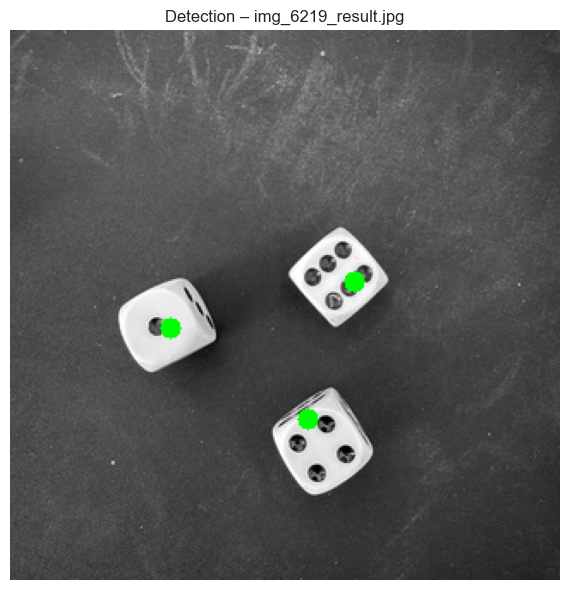

In [29]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# === Cesty ===
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model12x12'

# === Parametry ===
IMG_SIZE = (96, 96)
GRID_SIZE = (12, 12)
THRESHOLD = 0.35
NMS_SIZE = 3

# === Funkce ===
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

def load_random_image():
    image_files = glob.glob(os.path.join(VAL_DIR, '*.jpg'))
    img_path = np.random.choice(image_files)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_resized = cv2.resize(img, IMG_SIZE) / 255.0
    img_resized = np.expand_dims(img_resized, axis=-1)  # (H, W, 1)
    return img_color, np.expand_dims(img_resized.astype(np.float32), axis=0), os.path.basename(img_path)

# === Načtení modelu ===
model = tf.keras.models.load_model(
    os.path.join(MODEL_DIR, 'fomo_detector_tf'),
    compile=False
)

# === Predikce ===
orig_img, input_img, img_name = load_random_image()
h_orig, w_orig = orig_img.shape[:2]

pred = model.predict(input_img)[0].squeeze()
grid_h, grid_w = pred.shape
scale_x = w_orig / grid_w
scale_y = h_orig / grid_h

# === Detekce ===
detections = apply_nms(pred, threshold=THRESHOLD, size=NMS_SIZE)

for (y, x) in detections:
    cx = int((x + 0.5) * scale_x)
    cy = int((y + 0.5) * scale_y)
    cv2.circle(orig_img, (cx, cy), 6, (0, 255, 0), -1)

# === Zobrazení ===
plt.figure(figsize=(6, 6))
plt.imshow(orig_img)
plt.title(f"Detection – {img_name}")
plt.axis('off')
plt.tight_layout()
plt.show()


# Show heatmap

1/1 [==============================] - 0s 18ms/step


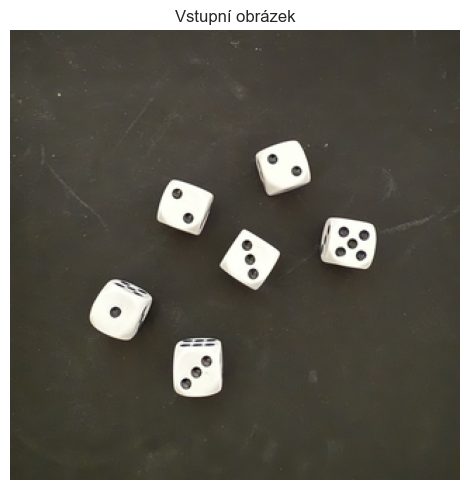

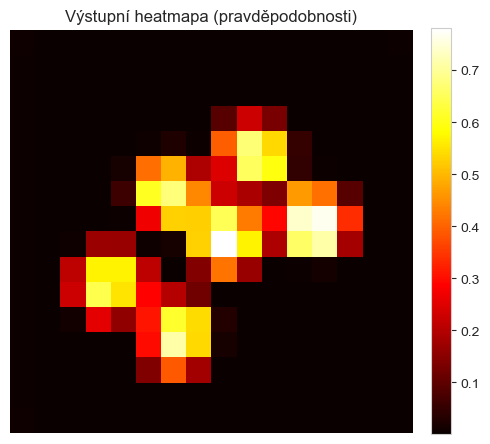

In [45]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model16x16'
MODEL_PATH = os.path.join(MODEL_DIR, 'fomo_detector_tf')

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)

# Načtení modelu
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Načti náhodný obrázek
image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
img_path = np.random.choice(image_files)
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
input_tensor = np.expand_dims(img_resized.astype(np.float32), axis=0)

# Předpověď a výstupní mapa
pred_map = model.predict(input_tensor)[0].squeeze()

# === Zobrazení vstupního obrázku ===
plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.title("Vstupní obrázek")
plt.axis('off')
plt.tight_layout()
plt.show()

# === Zobrazení heatmapy ===
plt.figure(figsize=(5, 5))
im = plt.imshow(pred_map, cmap='hot', interpolation='nearest',
                extent=(0, IMG_SIZE[0], IMG_SIZE[1], 0), aspect='equal')
plt.title("Výstupní heatmapa (pravděpodobnosti)")
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


# Show heatmap for optimalisation FOMO

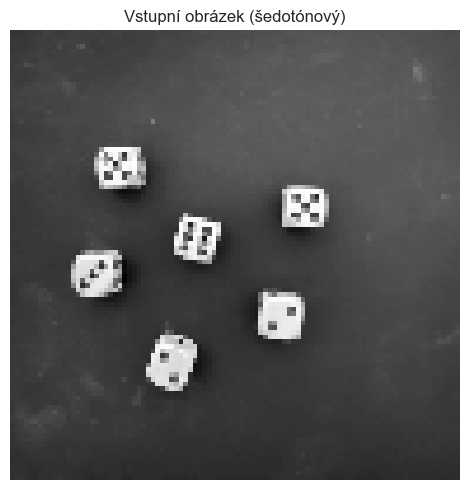

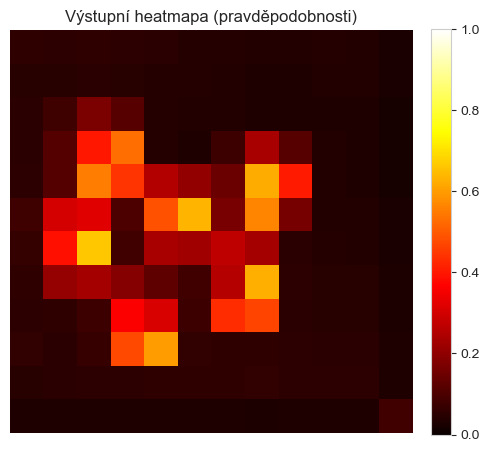

In [46]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# === Cesty ===
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model12x12'

# === Parametry ===
IMG_SIZE = (96, 96)
GRID_SIZE = (12, 12)

# === Načtení modelu ===
model = tf.keras.models.load_model(
    os.path.join(MODEL_DIR, 'fomo_detector_tf'),
    compile=False
)

# === Vyber náhodný obrázek ===
image_files = glob.glob(os.path.join(VAL_DIR, '*.jpg'))
img_path = np.random.choice(image_files)

# === Načti obrázek jako GRAYSCALE a připrav vstup ===
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img_gray, IMG_SIZE) / 255.0
img_input = np.expand_dims(img_resized, axis=(0, -1))  # (1, H, W, 1)

# === Předpověď ===
pred_map = model.predict(img_input, verbose=0)[0].squeeze()  # (12, 12)

# === Zobrazení původního obrázku ===
plt.figure(figsize=(5, 5))
plt.imshow(img_resized, cmap='gray')
plt.title("Vstupní obrázek (šedotónový)")
plt.axis('off')
plt.tight_layout()
plt.show()

# === Zobrazení heatmapy ===
plt.figure(figsize=(5, 5))
im = plt.imshow(pred_map, cmap='hot', interpolation='nearest', vmin=0.0, vmax=1.0)
plt.title("Výstupní heatmapa (pravděpodobnosti)")
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


# Show structure of model

Show input and output tensor

In [33]:
import tensorflow as tf

# Načtení modelu
interpreter = tf.lite.Interpreter(model_path="/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model12x12/fomo_detector_int8.tflite")
interpreter.allocate_tensors()

# Vstupy a výstupy
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Vstupní tensor:")
print(input_details)

print("Výstupní tensor:")
print(output_details)

Vstupní tensor:
[{'name': 'serving_default_input_7:0', 'index': 0, 'shape': array([ 1, 96, 96,  1], dtype=int32), 'shape_signature': array([-1, 96, 96,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Výstupní tensor:
[{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([ 1, 12, 12,  1], dtype=int32), 'shape_signature': array([-1, 12, 12,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## Confusion matrix

=== Výsledky FOMO detekce ===
TP: 68
FP: 3
FN: 10
Precision: 0.9577
Recall:    0.8718
F1-score:  0.9128


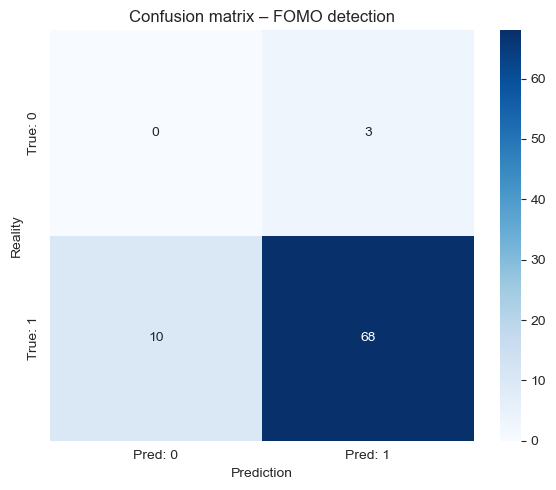

In [35]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import maximum_filter
from sklearn.metrics import confusion_matrix

# === Cesty ===
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Dataset/Dice/val'
MODEL_PATH = '/Volumes/DataHD/Tmp/PythonProjects/Python-model/TFlite/Model12x12/fomo_detector_tf'

# === Parametry ===
IMG_SIZE = (96, 96)
GRID_SIZE = (12, 12)
THRESHOLD = 0.4
NMS_SIZE = 3
DIST_TOLERANCE = 1.5  # tolerance vzdálenosti v grid buňkách

# === Funkce ===
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

def parse_label_file(txt_path):
    coords = []
    if not os.path.exists(txt_path):
        return coords
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, _, _ = map(float, parts)
                x_pixel = int(x_center * IMG_SIZE[0])
                y_pixel = int(y_center * IMG_SIZE[1])
                gx = min(x_pixel * GRID_SIZE[0] // IMG_SIZE[0], GRID_SIZE[0] - 1)
                gy = min(y_pixel * GRID_SIZE[1] // IMG_SIZE[1], GRID_SIZE[1] - 1)
                coords.append((gy, gx))
    return coords

# === Načti model ===
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

TP = 0
FP = 0
FN = 0
y_true_all = []
y_pred_all = []

image_files = glob.glob(os.path.join(VAL_DIR, '*.jpg'))

for img_path in image_files:
    txt_path = img_path.replace('.jpg', '.txt')
    gt_coords = parse_label_file(txt_path)

    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, IMG_SIZE) / 255.0
    img_input = np.expand_dims(img_resized, axis=(0, -1))

    pred_map = model.predict(img_input, verbose=0)[0].squeeze()
    pred_coords = apply_nms(pred_map, threshold=THRESHOLD, size=NMS_SIZE)

    matched_gt = set()
    matched_pred = set()

    for i, gt in enumerate(gt_coords):
        for j, pred in enumerate(pred_coords):
            if j in matched_pred:
                continue
            dist = np.linalg.norm(np.array(gt) - np.array(pred))
            if dist <= DIST_TOLERANCE:
                matched_gt.add(i)
                matched_pred.add(j)
                break

    TP += len(matched_gt)
    FP += len(pred_coords) - len(matched_pred)
    FN += len(gt_coords) - len(matched_gt)

    y_true_all += [1] * len(matched_gt) + [1] * (len(gt_coords) - len(matched_gt)) + [0] * (len(pred_coords) - len(matched_pred))
    y_pred_all += [1] * len(matched_gt) + [0] * (len(gt_coords) - len(matched_gt)) + [1] * (len(pred_coords) - len(matched_pred))

# === Výpočet metrik ===
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)

# === Výpis ===
print("=== Výsledky FOMO detekce ===")
print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# === Konfúzní matice ===
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred: 0", "Pred: 1"],
            yticklabels=["True: 0", "True: 1"])
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix – FOMO detection")
plt.tight_layout()
plt.show()
